In [1]:
pip install mljar-supervised

     |████████████████████████████████| 101 kB 3.2 MB/s 
     |████████████████████████████████| 9.9 MB 7.5 MB/s 
     |████████████████████████████████| 27.4 MB 54.4 MB/s 
     |████████████████████████████████| 1.7 MB 42.9 MB/s 
     |████████████████████████████████| 65.7 MB 50.5 MB/s 
     |████████████████████████████████| 42 kB 659 kB/s 
     |████████████████████████████████| 319 kB 57.9 MB/s 
     |████████████████████████████████| 215 kB 60.8 MB/s 
  Created wheel for mljar-supervised: filename=mljar_supervised-0.10.3-py3-none-any.whl size=134890 sha256=999c40bb9179997a79582dab0f75b76bba5888fdb1576c4cf227b6e6e68ccecc
  Stored in directory: /root/.cache/pip/wheels/a3/c8/5a/5c3617a8488b49cb9d5ae6b2d79b0e4e6ddcf381def60fde7f
  Created wheel for dtreeviz: filename=dtreeviz-1.0-py3-none-any.whl size=47219 sha256=0a14c5135bd5f1a5016690e27a6f495ac2f06e388179d7b2e7276af60967d988
  Stored in directory: /root/.cache/pip/wheels/0a/27/39/56e6216f118120c9a3d1c7a5f4ce96f06a98ccd20f691166fe


In [2]:
import numpy as np
import pandas as pd
import missingno as msno

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2021/test.csv')
final = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2021/sample_submission.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


# Understanding Data

In [4]:
print(train.shape)
print(test.shape)

(100000, 12)
(100000, 11)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,100000.000000,100000.000000,100000.000000,96708.000000,100000.000000,100000.000000,99866.00000
mean,49999.500000,0.427740,2.106910,38.355472,0.397690,0.454560,43.92933
std,28867.657797,0.494753,0.837727,18.313556,0.862566,0.950076,69.58882
min,0.000000,0.000000,1.000000,0.080000,0.000000,0.000000,0.68000
25%,24999.750000,0.000000,1.000000,25.000000,0.000000,0.000000,10.04000
50%,49999.500000,0.000000,2.000000,39.000000,0.000000,0.000000,24.46000
75%,74999.250000,1.000000,3.000000,53.000000,1.000000,1.000000,33.50000
max,99999.000000,1.000000,3.000000,87.000000,8.000000,9.000000,744.66000


In [7]:
train.isnull().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Ticket          4623
Fare             134
Cabin          67866
Embarked         250
dtype: int64

In [8]:
test.isnull().sum()

PassengerId        0
Pclass             0
Name               0
Sex                0
Age             3487
SibSp              0
Parch              0
Ticket          5181
Fare             133
Cabin          70831
Embarked         277
dtype: int64

In [9]:
missing_percentages = (train[train.columns].isnull().sum() / train.shape[0]) * 100
missing_percentages

PassengerId     0.000
Survived        0.000
Pclass          0.000
Name            0.000
Sex             0.000
Age             3.292
SibSp           0.000
Parch           0.000
Ticket          4.623
Fare            0.134
Cabin          67.866
Embarked        0.250
dtype: float64

In [10]:
missing_percentages_test = (test[test.columns].isnull().sum() / test.shape[0]) * 100
missing_percentages_test

PassengerId     0.000
Pclass          0.000
Name            0.000
Sex             0.000
Age             3.487
SibSp           0.000
Parch           0.000
Ticket          5.181
Fare            0.133
Cabin          70.831
Embarked        0.277
dtype: float64

### The columns with missing values are-

* Age
* Ticket
* Fare
* Cabin
* Embarked

# EDA

In [11]:
for i in train.columns:
    print("The number of unique values in {} is {}".format(i, len(train[i].unique())))

The number of unique values in PassengerId is 100000
The number of unique values in Survived is 2
The number of unique values in Pclass is 3
The number of unique values in Name is 92144
The number of unique values in Sex is 2
The number of unique values in Age is 174
The number of unique values in SibSp is 7
The number of unique values in Parch is 8
The number of unique values in Ticket is 75332
The number of unique values in Fare is 15936
The number of unique values in Cabin is 26993
The number of unique values in Embarked is 4


### The categorical features are
* Pclass
* Sex
* Embarked
* Parch
* SibSp

### The continuous features are
* Age
* Fare

### The ones which will be dealt manually are
* Ticket
* Cabin
* Name

In [12]:
categorical_features = ["Pclass","Sex","Embarked","Parch","SibSp"]
continuous_features = ["Age","Fare"]

## Checking the count & distribution of Survived


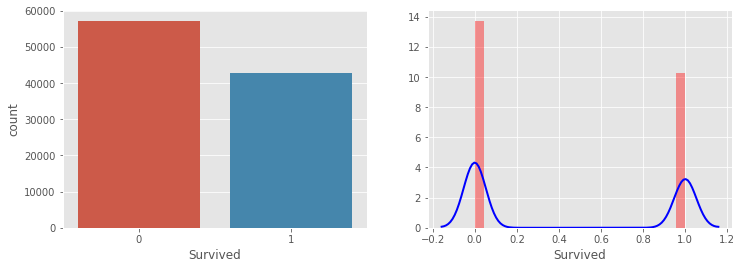

In [13]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ax = sns.countplot(x="Survived",data=train)
plt.subplot(1,2,2)
sns.distplot(train.loc[: ,'Survived'], hist_kws={"color":"r"}, kde_kws={"color":"b", "lw":2})
plt.show()

## Pclass

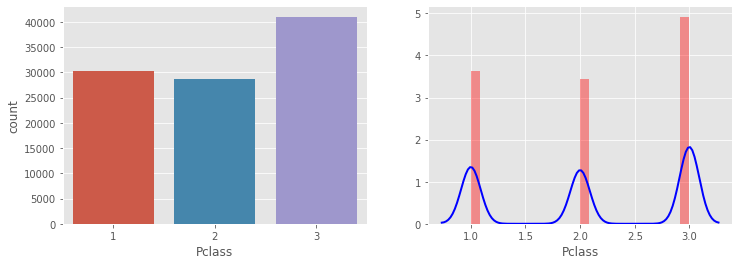

In [14]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ax = sns.countplot(x="Pclass",data=train)
plt.subplot(1,2,2)
sns.distplot(train.loc[: ,"Pclass"], hist_kws={"color":"r"}, kde_kws={"color":"b", "lw":2})
plt.show()

## Parch

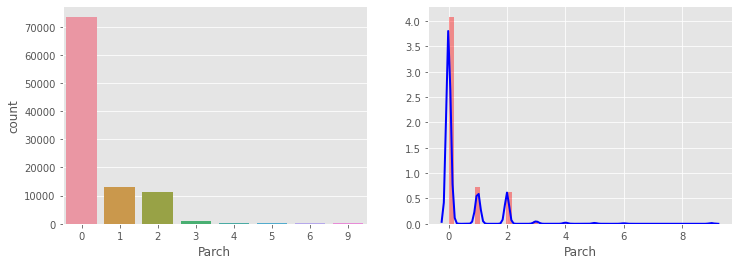

In [15]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ax = sns.countplot(x="Parch",data=train)
plt.subplot(1,2,2)
sns.distplot(train.loc[: ,"Parch"], hist_kws={"color":"r"}, kde_kws={"color":"b", "lw":2})
plt.show()

## SibSp

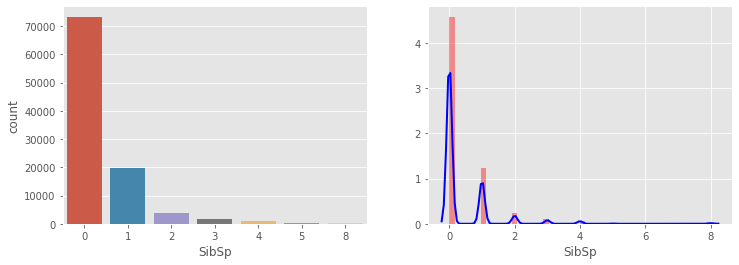

In [16]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ax = sns.countplot(x="SibSp",data=train)
plt.subplot(1,2,2)
sns.distplot(train.loc[: ,"SibSp"], hist_kws={"color":"r"}, kde_kws={"color":"b", "lw":2})
plt.show()

## Sex

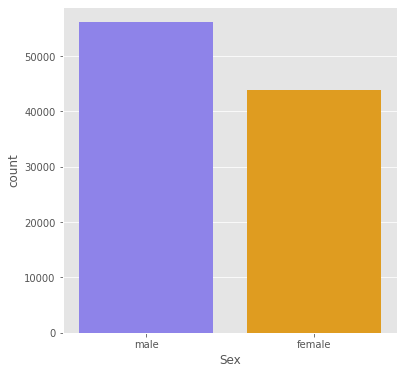

In [17]:
fig = plt.figure(figsize=(6,6))
sns.set_palette(["#8072fa","orange"])
ax = sns.countplot(x="Sex",data=train)
plt.show()

## Embarked

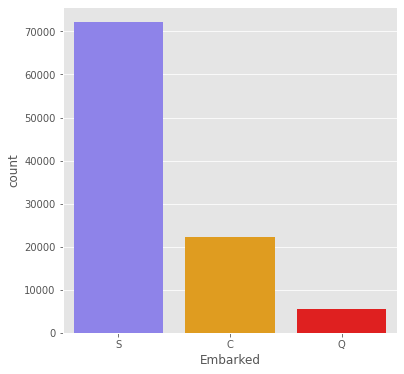

In [18]:
fig = plt.figure(figsize=(6,6))
sns.set_palette(["#8072fa","orange","Red"])
ax = sns.countplot(x="Embarked",data=train)
plt.show()

# Data Preprocessing

Handling missing data

In [19]:
train['Age'].fillna(train['Age'].mean(),inplace=True)
test['Age'].fillna(train['Age'].mean(),inplace=True)

train['Fare'].fillna(train['Fare'].mean(),inplace=True)
test['Fare'].fillna(train['Fare'].mean(),inplace=True)

train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)
test['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)

Ticket number,Cabin & Name number doesn't seem to influence Survival.

In [20]:
train.drop(['Name','Ticket','Cabin','PassengerId'], axis=1, inplace=True)
test.drop(['Name','Ticket','Cabin','PassengerId'], axis=1, inplace=True)

Applying a log function to reduce the influence of outliers in Fare column. Since there are a large number of outliers, removing them will lead to loss of a large numberof points.

In [21]:
train['Fare'] = train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
test['Fare'] = test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

Adding Parch and SibSp into one feature

In [22]:
train["relatives"] = train["Parch"] + train["SibSp"] + 1
test["relatives"] = test["Parch"] + test["SibSp"] + 1

# Model

Label Encoding the categorical features

In [23]:
object_cols = ['Sex','Embarked']
for col in object_cols:
    label_encoder = LabelEncoder()
    label_encoder.fit(train[col])
    train[col] = label_encoder.transform(train[col])
    test[col] = label_encoder.transform(test[col])

In [24]:
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','relatives']
target = train['Survived'].values

## Logistic Regression

In [25]:
lr = LogisticRegression()
lr.fit(train[features], target)
print("Logistic Regression ROC AUC score:", roc_auc_score(target, lr.predict_proba(train[features])[:,1]))
print('Logistic Regression Accuracy score:', accuracy_score(target, lr.predict(train[features])))

Logistic Regression ROC AUC score: 0.8285372252746173
Logistic Regression Accuracy score: 0.7662


In [26]:
final['Survived'] = lr.predict(test[features])
final.to_csv('LR.csv',index=False)

## XGBoost

In [27]:
xgb = XGBClassifier()
xgb.fit(train[features], target)
print("XGB ROC AUC score:", roc_auc_score(target, xgb.predict_proba(train[features])[:,1]))
print('XGB Accuracy score:', accuracy_score(target, xgb.predict(train[features])))

[05:08:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB ROC AUC score: 0.86427481424426
XGB Accuracy score: 0.79044


In [28]:
final['Survived'] = xgb.predict(test[features])
final.to_csv('XGB.csv',index=False)

# AutoML

In [29]:
from supervised.automl import AutoML
automl = AutoML(eval_metric="accuracy")
automl.fit(train[features], target)
automl.report()

Linear algorithm was disabled.
AutoML directory: AutoML_1
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline accuracy 0.57224 trained in 0.64 seconds
2_DecisionTree accuracy 0.76604 trained in 26.83 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost accuracy 0.77264 trained in 20.04 seconds
4_Default_NeuralNetwork accuracy 0.76624 trained in 40.16 seconds
5_Default_RandomForest accuracy 0.77004 trained in 17.56 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.77288 trained in 8.22 seconds
AutoML fit time: 118.95 seconds
AutoML best model: Ensemble


In [30]:
final['Survived'] = automl.predict(test[features])
final.to_csv('AutoML.csv',index=False)

# Decision Tree

In [31]:
model = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=2)
model.fit(train[features], target)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=2)

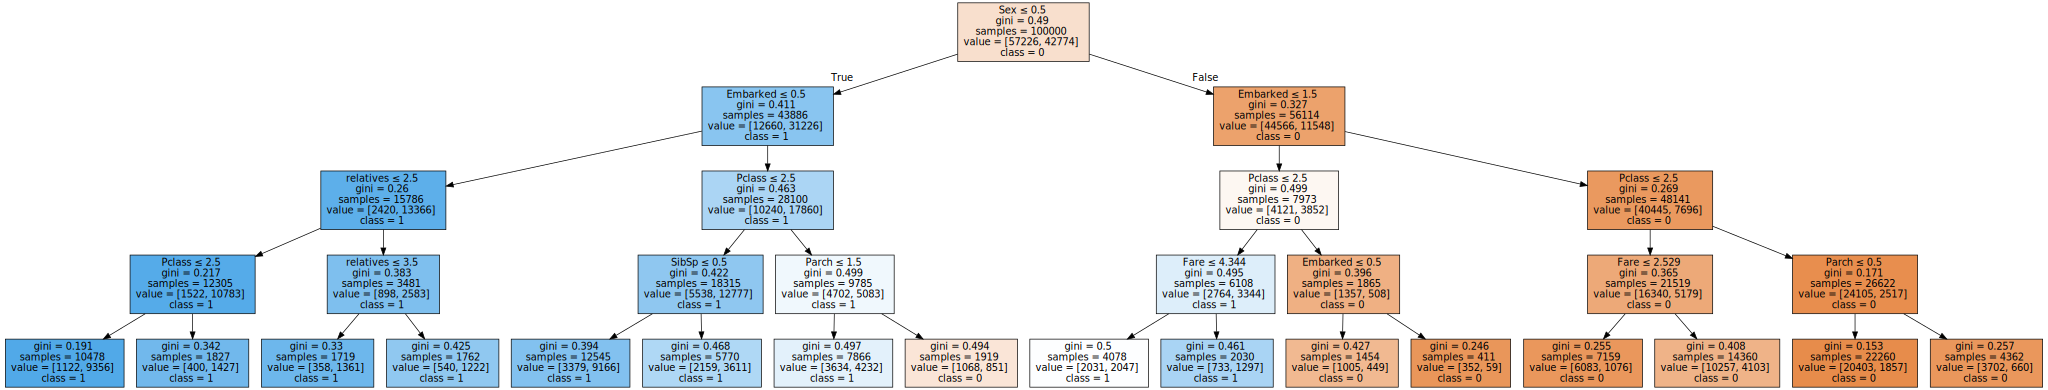

In [32]:
dot_data = export_graphviz(
    model,
    out_file=None,
    feature_names=train[features].columns,
    class_names=['0', '1'],
    filled=True,
    rounded=False,
    special_characters=True,
    precision=3
)
graph = graphviz.Source(dot_data)
graph 

In [33]:
y_pred = model.predict(test[features]).astype(int)
final['Survived'] = y_pred
final.to_csv("DT.csv", index=False)